# Few-Shot Q/A with GPT-3 Codex
This notebook demonstrates that providing GPT-3 Codex a few-shot context can improve its accuracy. The questions being asked are all complex machine learning questions, so Codex often answers them incorrectly at zero-shot. However, when we provide a few-shot context of similar questions, Codex is more likely to answer correctly.

## Imports

In [146]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import openai
import os
import time
from IPython.display import display, clear_output

## Import Data

In [147]:
data = pandas.read_csv('data.csv')
data.head()

,Id,Question,Solution,ChatGPT Answer,Grade 0/1,List of questions from most to least similar (do this only for 0s and list only 1s),Few-shot answer,Few-shot evaluation (only for zero-shot 0s)
0,1,Determine how many pixels of padding we need o...,"15. For an image of size $(x, x)$, a padding o...",To determine the amount of padding needed to e...,1,NaN,NaN,NaN
1,2,Which of the following are true of convolution...,"a, b, and c.",a) They are trained using backpropagation.\nc)...,0,NaN,NaN,NaN
2,3,Which of the following are true of pooling lay...,"a, c, d. \, b is false because pooling neither...",The correct answers are:\n\na) They reduce the...,1,NaN,NaN,NaN
3,4,Consider the following CNN architecture:\n\nIn...,The learnable parameters in this CNN architect...,The total number of parameters in this network...,0,NaN,NaN,NaN
4,5,What is the convolution of filter $K$ with ima...,"[[3, -3], [3, -3]].",The convolution of filter $K$ with image $X$ c...,0,NaN,NaN,NaN


## Get Word Embeddings of Questions
Embed the `Question` column of `data` using OpenAi's `text-embedding-ada-002`

In [148]:
def get_embeddings(data):
    openai.api_key=os.getenv("OPENAI_API_KEY")
    response = openai.Embedding.create(
        input=data['Question'].to_list(),
        model="text-embedding-ada-002"
    )
    embeddings = []

    for i in range(len(response['data'])):
        embeddings.append(response['data'][i]['embedding'])

    print(len(embeddings), "embeddings retreived")

    data['Embedding'] = embeddings

    return data

data = get_embeddings(data)
data.head()

22 embeddings retreived


,Id,Question,Solution,ChatGPT Answer,Grade 0/1,List of questions from most to least similar (do this only for 0s and list only 1s),Few-shot answer,Few-shot evaluation (only for zero-shot 0s),Embedding
0,1,Determine how many pixels of padding we need o...,"15. For an image of size $(x, x)$, a padding o...",To determine the amount of padding needed to e...,1,NaN,NaN,NaN,"[0.0491814985871315, 0.016239942982792854, 0.0..."
1,2,Which of the following are true of convolution...,"a, b, and c.",a) They are trained using backpropagation.\nc)...,0,NaN,NaN,NaN,"[-0.004106645938009024, 0.015915250405669212, ..."
2,3,Which of the following are true of pooling lay...,"a, c, d. \, b is false because pooling neither...",The correct answers are:\n\na) They reduce the...,1,NaN,NaN,NaN,"[-0.013904008083045483, 0.02738708257675171, 0..."
3,4,Consider the following CNN architecture:\n\nIn...,The learnable parameters in this CNN architect...,The total number of parameters in this network...,0,NaN,NaN,NaN,"[0.016081923618912697, 0.0036484559532254934, ..."
4,5,What is the convolution of filter $K$ with ima...,"[[3, -3], [3, -3]].",The convolution of filter $K$ with image $X$ c...,0,NaN,NaN,NaN,"[0.020113302394747734, 0.01932581141591072, -0..."


## Calculate the Cosine Similarity of Embeddings

In [149]:
# List of questions "Id" from most to least similar (do this only for rows with for 0s for 'Grade 0/1' column and list only 'Id' of rows with 1s for 'Grade 0/1' column)
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def get_similar_questions(row):
    if row['Grade 0/1'] == 1:
        return []
    else:
        similarities = []
        for i in range(len(data)):
            if data.iloc[i]['Grade 0/1'] == 1:
                similarities.append((i, cosine_similarity(row['Embedding'], data.iloc[i]['Embedding'])))
        similarities.sort(key=lambda x: x[1], reverse=True)
        return [data.iloc[i]['Id'] for i, _ in similarities]

data['List of questions from most to least similar (do this only for 0s and list only 1s)'] = data.apply(get_similar_questions, axis=1)
data.head()

,Id,Question,Solution,ChatGPT Answer,Grade 0/1,List of questions from most to least similar (do this only for 0s and list only 1s),Few-shot answer,Few-shot evaluation (only for zero-shot 0s),Embedding
0,1,Determine how many pixels of padding we need o...,"15. For an image of size $(x, x)$, a padding o...",To determine the amount of padding needed to e...,1,[],NaN,NaN,"[0.0491814985871315, 0.016239942982792854, 0.0..."
1,2,Which of the following are true of convolution...,"a, b, and c.",a) They are trained using backpropagation.\nc)...,0,"[11, 3, 14, 10, 13, 22, 9, 17, 8, 20, 15, 1, 19]",NaN,NaN,"[-0.004106645938009024, 0.015915250405669212, ..."
2,3,Which of the following are true of pooling lay...,"a, c, d. \, b is false because pooling neither...",The correct answers are:\n\na) They reduce the...,1,[],NaN,NaN,"[-0.013904008083045483, 0.02738708257675171, 0..."
3,4,Consider the following CNN architecture:\n\nIn...,The learnable parameters in this CNN architect...,The total number of parameters in this network...,0,"[10, 8, 3, 11, 1, 13, 14, 15, 19, 22, 9, 20, 17]",NaN,NaN,"[0.016081923618912697, 0.0036484559532254934, ..."
4,5,What is the convolution of filter $K$ with ima...,"[[3, -3], [3, -3]].",The convolution of filter $K$ with image $X$ c...,0,"[8, 9, 10, 1, 11, 15, 19, 3, 13, 17, 14, 22, 20]",NaN,NaN,"[0.020113302394747734, 0.01932581141591072, -0..."


## Generate Few-Shot Inputs

In [150]:
def generate_few_shot_input(row, few_shot_examples=3):
    few_shot_input = ""
    if row['Grade 0/1'] == 1:
        # Correct via zero-shot
        few_shot_input = "n/a"
    elif row['Grade 0/1'] == 0:
        # Incorrect via zero-shot, so generate few-shot input
        # Get the most similar questions and their answers
        similar_questions = row['List of questions from most to least similar (do this only for 0s and list only 1s)']
        similar_questions = similar_questions[:few_shot_examples]
        for i in similar_questions:
            few_shot_input += "QUESTION:\n" + data.iloc[i-1]['Question'] + "\n"
            few_shot_input += "ANSWER:\n" +data.iloc[i-1]['ChatGPT Answer'] + "\n-----\n"
        few_shot_input += "QUESTION:\n" + row['Question']
    return few_shot_input

data['Few-shot input'] = data.apply(generate_few_shot_input, axis=1)
data.head()

,Id,Question,Solution,ChatGPT Answer,Grade 0/1,List of questions from most to least similar (do this only for 0s and list only 1s),Few-shot answer,Few-shot evaluation (only for zero-shot 0s),Embedding,Few-shot input
0,1,Determine how many pixels of padding we need o...,"15. For an image of size $(x, x)$, a padding o...",To determine the amount of padding needed to e...,1,[],NaN,NaN,"[0.0491814985871315, 0.016239942982792854, 0.0...",n/a
1,2,Which of the following are true of convolution...,"a, b, and c.",a) They are trained using backpropagation.\nc)...,0,"[11, 3, 14, 10, 13, 22, 9, 17, 8, 20, 15, 1, 19]",NaN,NaN,"[-0.004106645938009024, 0.015915250405669212, ...",QUESTION:\nWhich of the following are true of ...
2,3,Which of the following are true of pooling lay...,"a, c, d. \, b is false because pooling neither...",The correct answers are:\n\na) They reduce the...,1,[],NaN,NaN,"[-0.013904008083045483, 0.02738708257675171, 0...",n/a
3,4,Consider the following CNN architecture:\n\nIn...,The learnable parameters in this CNN architect...,The total number of parameters in this network...,0,"[10, 8, 3, 11, 1, 13, 14, 15, 19, 22, 9, 20, 17]",NaN,NaN,"[0.016081923618912697, 0.0036484559532254934, ...",QUESTION:\nConsider one layer of weights in a ...
4,5,What is the convolution of filter $K$ with ima...,"[[3, -3], [3, -3]].",The convolution of filter $K$ with image $X$ c...,0,"[8, 9, 10, 1, 11, 15, 19, 3, 13, 17, 14, 22, 20]",NaN,NaN,"[0.020113302394747734, 0.01932581141591072, -0...",QUESTION:\nHow many weights are in the max poo...


## Generate Few-Shot Outputs

In [151]:
def get_few_shot_answer(row):
    if row['Grade 0/1'] == 1:
        print("Question " + str(row['Id']) + " is correct via zero-shot")
        return "n/a"
    else:
        # Random sleep because my code is too efficient and OpenAI's is mad at me
        time.sleep(5)
        openai.api_key=os.getenv("OPENAI_API_KEY")
        response = openai.Completion.create(
            model="code-davinci-002",
            prompt=row['Few-shot input'],
            temperature=0,
            top_p=0,
            max_tokens=512
            )
        print("Question " + str(row['Id']) + " few-shot answer generated")
        return response['choices'][0]['text']
    
data['Few-shot answer'] = data.apply(get_few_shot_answer, axis=1)

Question 1 is correct via zero-shot
Question 2 few-shot answer generated
Question 3 is correct via zero-shot
Question 4 few-shot answer generated
Question 5 few-shot answer generated
Question 6 few-shot answer generated
Question 7 few-shot answer generated
Question 8 is correct via zero-shot
Question 9 is correct via zero-shot
Question 10 is correct via zero-shot
Question 11 is correct via zero-shot
Question 12 few-shot answer generated
Question 13 is correct via zero-shot
Question 14 is correct via zero-shot
Question 15 is correct via zero-shot
Question 16 few-shot answer generated
Question 17 is correct via zero-shot
Question 18 few-shot answer generated
Question 19 is correct via zero-shot
Question 20 is correct via zero-shot
Question 21 few-shot answer generated
Question 22 is correct via zero-shot


## Manual Evaluation of Few-Shot Answers

In [155]:
def evaluate_few_shot_answer(row):
    clear_output(wait=True)
    if row['Grade 0/1'] == 1:
        return "n/a"
    else:
        print("Id " + str(row['Id']))
        print("Question: " + str(row['Question']) + "\n---\n" + "Solution: " + str(row['Solution']) + "\n---\n" +"Few-shot answer: " + str(row['Few-shot answer']))
        return input("Id " + str(row['Id']) + ": Is the few-shot answer correct? (0/1) ")
    
clear_output(wait=True)
data['Few-shot evaluation (only for zero-shot 0s)'] = data.apply(evaluate_few_shot_answer, axis=1)

Id 21
Question: Select the best type of model for each use case, matching the use case to the options provided:

\noindent
Use cases:
\begin{enumerate}[label=\alph*.]
    \item[1.]
    Tumor segmentation analysis or recognizing tumor patches in medical ``slides''.
    \item[2.]
    Sentiment analysis on a large text corpus.
    \item[3.]
    Time series forecasting to predict price of automobile in the next month.
    \item[4.]
    Predict the price of a house based on square feet, ratio of bedrooms/bathrooms.
\end{enumerate}

\noindent
Options: CNN, RNN, Fully connected neural network
---
Solution: (1) CNN, (2) RNN, (3) RNN, (4) Fully connected neural network.
---
Few-shot answer: , Transformer

\noindent
ANSWER:

\noindent
1. CNN
2. RNN
3. RNN
4. Fully connected neural network
-----
QUESTION:
Consider a convolutional neural network with the following architecture:

\begin{enumerate}[label=\alph*.]
    \item[a.]
    What is the size of the output of the first convolutional layer?
    

## Evaluation of Results

Correct answers before few-shot: 13
Correct answers after few-shot: 16
Improvement: 3
Percent accuracy before few-shot: 59.09%
Percent accuracy after few-shot: 72.73%
Percent improvement: 13.64%


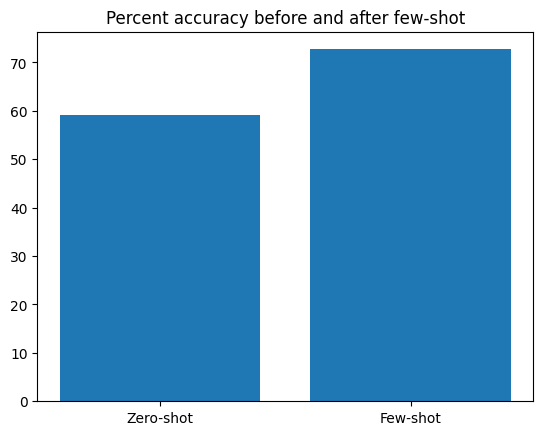

In [167]:
def evaluate_results():
    # Get the number of correct answers before and after few-shot
    correct_zero_shot = 0
    correct_few_shot = 0
    for i in range(len(data)):
        if data.iloc[i]['Grade 0/1'] == 1:
            correct_zero_shot += 1
            correct_few_shot += 1
        else:
            if data.iloc[i]['Few-shot evaluation (only for zero-shot 0s)'] == '1':
                correct_few_shot += 1
    print("Correct answers before few-shot: " + str(correct_zero_shot))
    print("Correct answers after few-shot: " + str(correct_few_shot))
    
    # Print the number improvement
    number_improvement = correct_few_shot - correct_zero_shot
    print("Improvement: " + str(number_improvement))

    # Get the percent accuracy before and after few-shot
    percent_accuracy_zero_shot = round((correct_zero_shot / len(data)) * 100, 2)
    percent_accuracy_few_shot = round((correct_few_shot / len(data)) * 100, 2)
    print("Percent accuracy before few-shot: " + str(percent_accuracy_zero_shot) + "%")
    print("Percent accuracy after few-shot: " + str(percent_accuracy_few_shot) + "%")


    # Print the percent improvement
    percent_improvement = round(percent_accuracy_few_shot - percent_accuracy_zero_shot, 2)
    print("Percent improvement: " + str(percent_improvement) + "%")

    # Graph the percent accuracy before and after few-shot
    plt.bar(['Zero-shot', 'Few-shot'], [percent_accuracy_zero_shot, percent_accuracy_few_shot])
    plt.title('Percent accuracy before and after few-shot')
    plt.show()

evaluate_results()
pandas.set_option('display.max_colwidth', None)
# display(data[['Id','Grade 0/1','List of questions from most to least similar (do this only for 0s and list only 1s)','Few-shot answer','Few-shot evaluation (only for zero-shot 0s)']])